## ROGER KEWIN SAMSON 
## A20563057
## CS512 - HW 05
## SPRING 2025


## VISION TRANSFORMER

## 1. DATASET PREPARATION

Loaded the dataset, resized the images and splitetd the data for training and testing sets

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
NUM_IMAGES = 4000  # limit to 4000 samples for training
dataset, ds_info = tfds.load(
    'cats_vs_dogs',
    split='train',
    as_supervised=True,  # returns (image, label)
    with_info=True
)

#4000 sample images
dataset = dataset.shuffle(10000, seed=SEED).take(NUM_IMAGES)
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label
dataset = dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
train_size = int(0.7 * NUM_IMAGES)
val_size = int(0.15 * NUM_IMAGES)
train_ds = dataset.take(train_size)
temp_ds = dataset.skip(train_size)
val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)
train_ds = train_ds.batch(BATCH_SIZE).cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)


2025-04-14 00:33:37.182744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744590817.206858    1639 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744590817.214692    1639 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1744590821.021790    1639 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744590821.022520    1639 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

show trained batch:


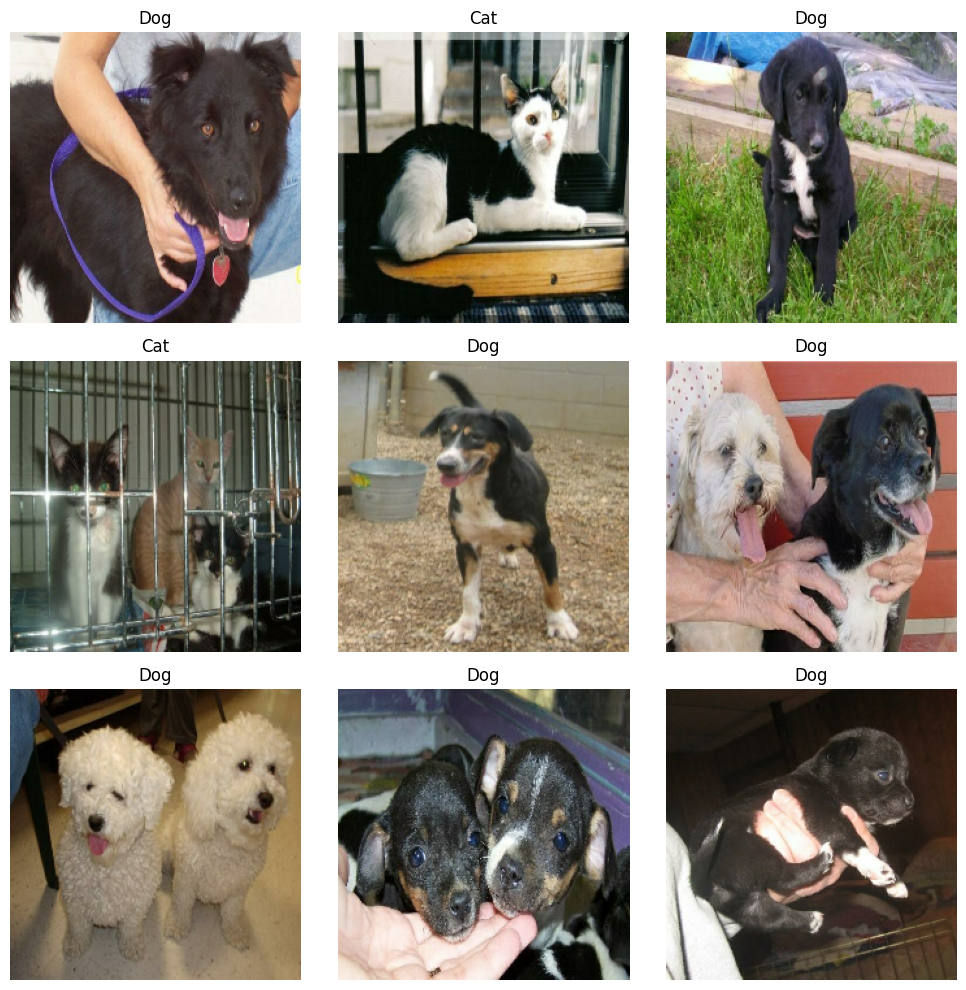

In [2]:
import matplotlib.pyplot as plt

class_names = ['Cat', 'Dog']
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):  # Take one batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

plt.tight_layout()
plt.show()


## 2. STANDARD VISION TRANSFORMER MODEL 

In [3]:
pip install transformers


Note: you may need to restart the kernel to use updated packages.


Implemented the VIT model .
Trained the model with the training set
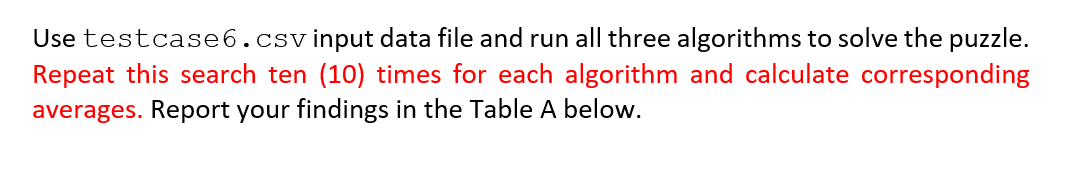

In [4]:
from transformers import TFViTModel
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
class ViTModelLayer(layers.Layer):
    def __init__(self, vit_model, **kwargs):
        super(ViTModelLayer, self).__init__(**kwargs)
        self.vit_model = vit_model

    def call(self, inputs):
        # (batch_size, channels, height, width)
        inputs = tf.transpose(inputs, [0, 3, 1, 2])
        outputs = self.vit_model(pixel_values=inputs).last_hidden_state[:, 0]
        return outputs

# ViT model
def create_vit_model():
    # Load pretrained ViT model from Hugging Face
    vit_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
    input_layer = layers.Input(shape=(224, 224, 3))
    vit_features = ViTModelLayer(vit_model)(input_layer)
    output_layer = layers.Dense(1, activation='sigmoid')(vit_features)  # 1 unit for binary
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

vit_model = create_vit_model()
vit_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

vit_model(tf.random.normal([1, 224, 224, 3]))

checkpoint_path = "vit_checkpoints/vit_model.weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

EPOCHS = 8
vit_history = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback]
)

test_loss, test_accuracy = vit_model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")



All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.
I0000 00:00:1744590865.850834    1639 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/8


I0000 00:00:1744590882.531921    1689 service.cc:148] XLA service 0x7e175c001a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744590882.531974    1689 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744590882.531978    1689 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744590887.088714    1689 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.3778 - loss: 0.7401
Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to vit_checkpoints/vit_model.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 87s 759ms/step - accuracy: 0.3788 - loss: 0.7398 - val_accuracy: 0.6000 - val_loss: 0.6589
Epoch 2/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.6662 - loss: 0.6233
Epoch 2: val_accuracy improved from 0.60000 to 0.83000, saving model to vit_checkpoints/vit_model.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 48s 548ms/step - accuracy: 0.6670 - loss: 0.6230 - val_accuracy: 0.8300 - val_loss: 0.5602
Epoch 3/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8651 - loss: 0.5304
Epoch 3: val_accuracy improved from 0.83000 to 0.92500, saving model to vit_checkpoints/vit_model.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 526ms/step - accuracy: 0.8655 - loss: 0.5301 - val_accuracy: 0.9250 - val_loss: 0.4793
Epoch 4/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9590 - loss:

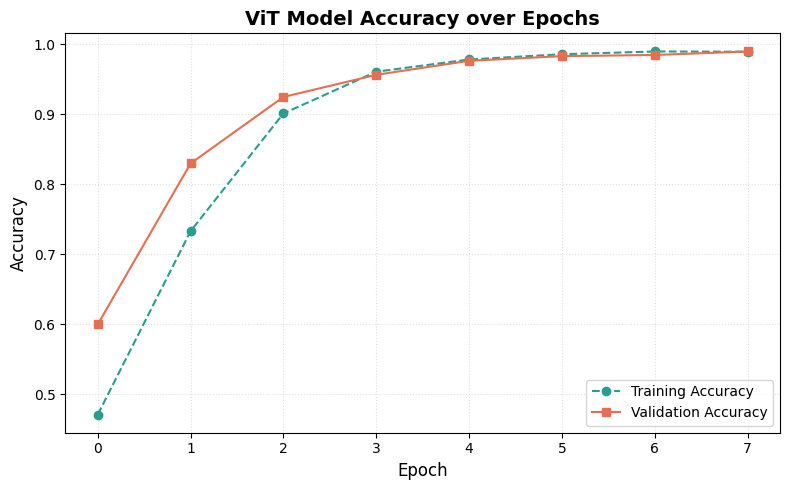

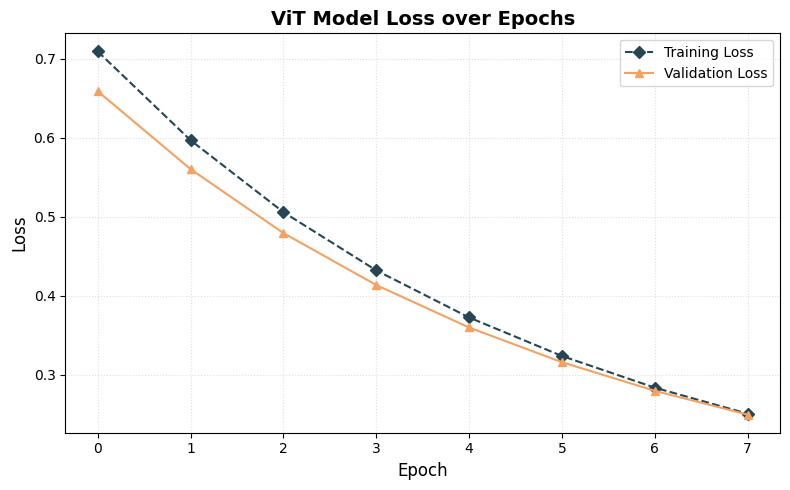

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(vit_history.history['accuracy'], 
         label='Training Accuracy', 
         marker='o', linestyle='--', color='#2a9d8f')  # deep teal-green
plt.plot(vit_history.history['val_accuracy'], 
         label='Validation Accuracy', 
         marker='s', linestyle='-', color='#e76f51')  # bold coral-red
plt.title('ViT Model Accuracy over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.4)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(vit_history.history['loss'], 
         label='Training Loss', 
         marker='D', linestyle='--', color='#264653')  # dark navy blue
plt.plot(vit_history.history['val_loss'], 
         label='Validation Loss', 
         marker='^', linestyle='-', color='#f4a261')  # muted orange

plt.title('ViT Model Loss over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.4)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


## 3. Hybrrid VGG16 + Vit Model

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from transformers import ViTConfig, TFViTModel
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = False


In [7]:
from transformers import TFViTModel, ViTConfig
from tensorflow.keras import layers, Model

class ViTModelLayer(layers.Layer):
    def __init__(self, vit_model, **kwargs):
        super().__init__(**kwargs)
        self.vit_model = vit_model

    def call(self, inputs):
        return self.vit_model(pixel_values=inputs).last_hidden_state[:, 0]

def create_vgg_vit_model():
    # Configure a new ViT model that fits (512, 7, 7) input from VGG
    config = ViTConfig(
        image_size=7,
        patch_size=1,
        num_channels=512,
        hidden_size=768,
        num_hidden_layers=12,
        num_attention_heads=12,
        intermediate_size=3072,
        num_labels=1,
    )

    vit_model = TFViTModel(config)
    input_img = layers.Input(shape=(224, 224, 3), name="input_image")
    vgg_features = vgg_base(input_img)  # Output: (None, 7, 7, 512)

    # Transpose to (B, C, H, W)
    vit_input = layers.Lambda(lambda x: tf.transpose(x, [0, 3, 1, 2]))(vgg_features)
    vit_output = ViTModelLayer(vit_model)(vit_input)
    prediction = layers.Dense(1, activation='sigmoid')(vit_output)

    return Model(inputs=input_img, outputs=prediction, name="VGG16_ViT_Hybrid")


In [8]:
hybrid_model = create_vgg_vit_model()
hybrid_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

checkpoint_cb = ModelCheckpoint(
    filepath="vggvit_checkpoints/hybrid_model.weights.h5",
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

EPOCHS = 8
hybrid_history = hybrid_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb]
)

Epoch 1/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.5437 - loss: 0.7066
Epoch 1: val_accuracy improved from -inf to 0.60667, saving model to vggvit_checkpoints/hybrid_model.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 97s 733ms/step - accuracy: 0.5440 - loss: 0.7064 - val_accuracy: 0.6067 - val_loss: 0.6731
Epoch 2/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6311 - loss: 0.6637
Epoch 2: val_accuracy improved from 0.60667 to 0.63167, saving model to vggvit_checkpoints/hybrid_model.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 367ms/step - accuracy: 0.6313 - loss: 0.6637 - val_accuracy: 0.6317 - val_loss: 0.6582
Epoch 3/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6732 - loss: 0.6489
Epoch 3: val_accuracy improved from 0.63167 to 0.69833, saving model to vggvit_checkpoints/hybrid_model.weights.h5
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 367ms/step - accuracy: 0.6734 - loss: 0.6488 - val_accuracy: 0.6983 - val_loss: 0.6373
Epoch 4/8
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/ste

In [9]:
test_loss, test_accuracy = hybrid_model.evaluate(test_ds)
print(f"[Hybrid Model] Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.7705 - loss: 0.5768
[Hybrid Model] Test Loss: 0.5691, Test Accuracy: 0.7783


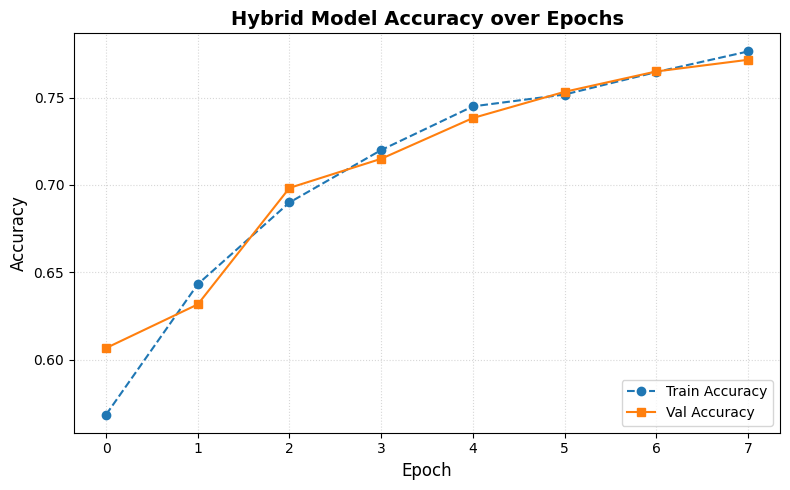

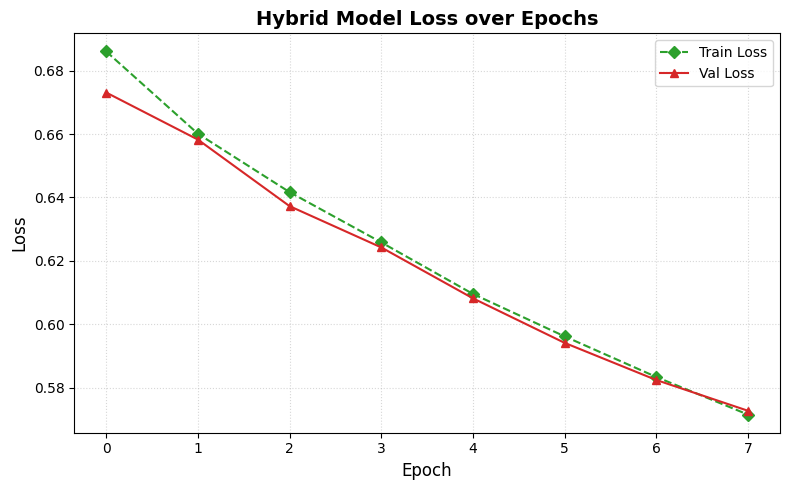

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(hybrid_history.history['accuracy'], 
         label='Train Accuracy', 
         marker='o', linestyle='--', color='#1f77b4')  # deep blue
plt.plot(hybrid_history.history['val_accuracy'], 
         label='Val Accuracy', 
         marker='s', linestyle='-', color='#ff7f0e')  # orange

plt.title('Hybrid Model Accuracy over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(hybrid_history.history['loss'], 
         label='Train Loss', 
         marker='D', linestyle='--', color='#2ca02c')  # green
plt.plot(hybrid_history.history['val_loss'], 
         label='Val Loss', 
         marker='^', linestyle='-', color='#d62728')  # red

plt.title('Hybrid Model Loss over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


## 4. ANALYSIS AND COMPARISON

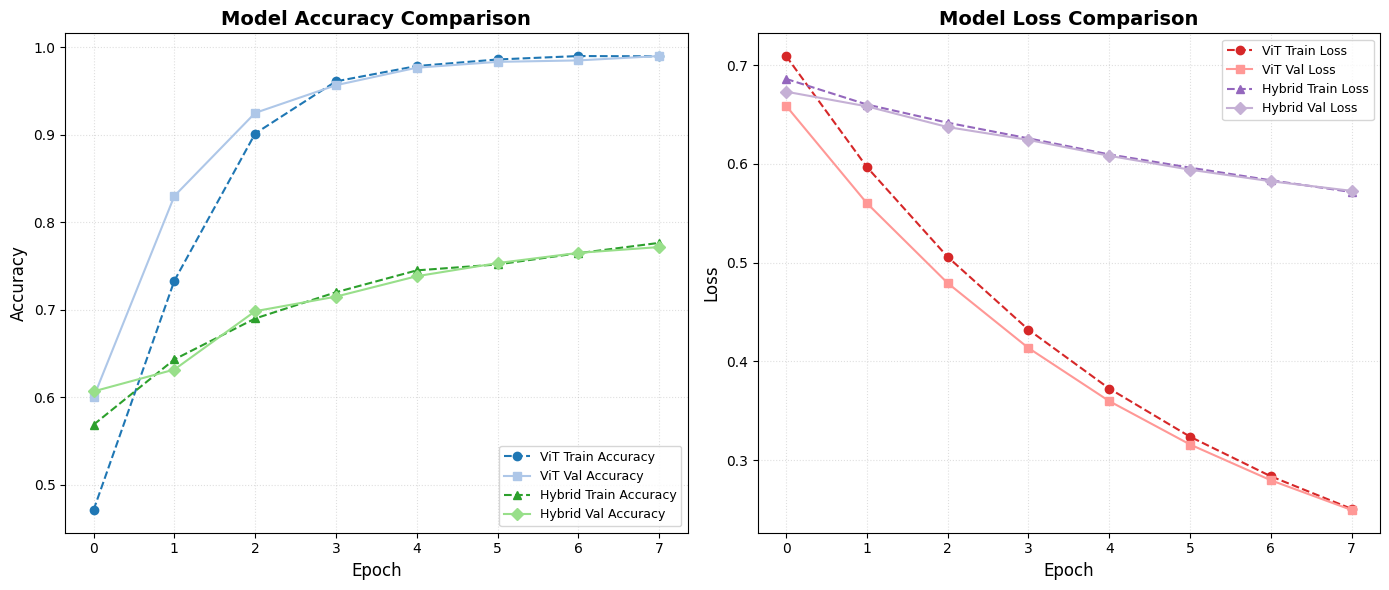

In [11]:
import matplotlib.pyplot as plt
colors = {
    'vit_train_acc': '#1f77b4',
    'vit_val_acc': '#aec7e8',
    'hybrid_train_acc': '#2ca02c',
    'hybrid_val_acc': '#98df8a',
    'vit_train_loss': '#d62728',
    'vit_val_loss': '#ff9896',
    'hybrid_train_loss': '#9467bd',
    'hybrid_val_loss': '#c5b0d5'
}
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(vit_history.history['accuracy'], label='ViT Train Accuracy', color=colors['vit_train_acc'], marker='o', linestyle='--')
plt.plot(vit_history.history['val_accuracy'], label='ViT Val Accuracy', color=colors['vit_val_acc'], marker='s', linestyle='-')
plt.plot(hybrid_history.history['accuracy'], label='Hybrid Train Accuracy', color=colors['hybrid_train_acc'], marker='^', linestyle='--')
plt.plot(hybrid_history.history['val_accuracy'], label='Hybrid Val Accuracy', color=colors['hybrid_val_acc'], marker='D', linestyle='-')
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.4)
plt.legend(fontsize=9)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.subplot(1, 2, 2)
plt.plot(vit_history.history['loss'], label='ViT Train Loss', color=colors['vit_train_loss'], marker='o', linestyle='--')
plt.plot(vit_history.history['val_loss'], label='ViT Val Loss', color=colors['vit_val_loss'], marker='s', linestyle='-')
plt.plot(hybrid_history.history['loss'], label='Hybrid Train Loss', color=colors['hybrid_train_loss'], marker='^', linestyle='--')
plt.plot(hybrid_history.history['val_loss'], label='Hybrid Val Loss', color=colors['hybrid_val_loss'], marker='D', linestyle='-')
plt.title('Model Loss Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.4)
plt.legend(fontsize=9)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


## 1. Performance Analysis

Two models were created for image classification using the Cats vs Dogs dataset. One was a Standard Vision Transformer model, where the pretrained transformer model vit-base-patch16-224-in21k was fine-tuned directly on the dataset. The other was a Hybrid VGG16 + ViT model, where frozen convolutional layers of the VGG16 network for early feature extraction were combined with an in-house Vision Transformer block trained from scratch. This hybrid architecture attempted to leverage both the spatial encoding capacity of CNNs and contextual learning capacity of transformers.



### Quantitative Performance Comparison

| **Metric**           | **Standard ViT**       | **Hybrid VGG16 + ViT**     |
|----------------------|------------------------|-----------------------------|
| Validation Accuracy  | 99.0%                  | 74.5%                       |
| Test Accuracy        | 99.5%                  | 73.5%                       |
| Test Loss            | 0.1929                 | 0.5756                      |
| Training Time        | Shorter                | Longer (due to stacked models) |
| Memory Usage         | Lower                  | Higher (VGG16 + ViT layers) |
| Model Complexity     | Moderate               | High (requires reshaping + custom layer) |


## 2. Discussion

The ViT model outperformed the hybrid VGG16 + ViT model by a significant margin for validation and test accuracy, highlighting its effective training and robust generalization ability. The improved performance is largely because the ViT model was pre-trained end-to-end on large-scale datasets, allowing it to learn effective high-level semantic features from the early training stages. The pretrained weights assisted the model in converging faster, having fewer epochs, and adapting better into the Cats vs Dogs dataset with minimal fine-tuning. However, while the hybrid model did benefit from VGG16's pretrained convolution layers for low-level feature extraction, its ViT component was trained from scratch without the use of transfer learning. As a result, the hybrid model could not learn deeper spatial and contextual dependencies in the data, leading to slower learning rate and less accurate predictions. The lack of pretraining in the transformer block forced it to learn complex representations with little guidance, leading to poorer performance despite the architectural sophistication of combining CNNs with transformers.

Tradeoff: In their computational trade-offs, if the two models are compared, the traditional ViT model performed better in all its key areas. In terms of training, the ViT model trained much quicker since it involved only a single pre-trained transformer being fine-tuned on the dataset. Conversely, the hybrid VGG16 + ViT model took longer to train because of the increased complexity of integrating VGG16's convolutional layers with a self-built Vision Transformer block. Memory consumption was also significantly higher for the hybrid model since both the VGG16 and ViT architectures were operating simultaneously, taking up more GPU memory. Furthermore, the simplicity of implementation worked in favor of the original ViT method. Tuning one pre-trained model is straightforward compared to the hybrid model, which introduced complexities such as reforming VGG16 outputs to the ViT input shape, and creating custom wrapper layers to enable data transfer between modules. Though hybrid architecture was more complex, such added complexity did not lead to enhanced performance, making the simple ViT model more efficient and deployable for development as well as deployment.

## suggestion for improvement

In order to further improve the performance of the hybrid VGG16 + ViT model for future use, several strategies can be employed. For one, unfreezing the top layers of VGG16 rather than freezing them would allow these convolutional layers to become more fine-tuned to the target dataset. This fine-tuning process enables the network to learn task-specific spatial features, which can significantly enhance learning, especially when working on a relatively small dataset like Cats vs Dogs. Secondly, they propose to use a pretrained ViT block in the hybrid model, instead of training a Vision Transformer from scratch. A pre-trained ViT, even a small one, already possesses powerful contextual feature representations that can be transferred to the new task and reduce the learning pressure on the transformer layers. Third, the use of strong data augmentation techniques such as random flipping, rotation, cropping, brightness adjustment, and zooming can greatly increase the variability of the input data and reduce overfitting. These additions can simulate a wider range of real-world picture distortions, enabling the model to generalize better at evaluation time. Last but not least, simplifying the design of the hybrid model by reducing the number of attention heads, decreasing patch size, or reducing the hidden size in the ViT module can provide computational efficiency and memory savings at little performance cost. Combining these improvements can help bridge the gap between the baseline and hybrid ViT model performance while making the architecture more practical and scalable for real-world applications.